# Emoji 表情生成器

## 导入使用的库

In [1]:
import random
import twitter
import emoji
# import itertools
import pandas as pd
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#from sklearn.model_selection import train_test_split
from keras import Sequential, optimizers, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
import keras.callbacks
from keras.backend import clear_session
#import json

import os
# import nb_utils
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Embedding, GlobalMaxPooling1D#, Merge 
from keras.models import Model
from keras.layers.merge import Concatenate, Average

# from gensim.models import Word2Vec

Using TensorFlow backend.


## 对数据集进行统计分析

In [2]:
all_tweets = pd.read_csv('data/emojis_homemade.csv')
all_tweets['emoji'].value_counts()

/Users/wujue/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


😂        70866
😭        28812
❤        23972
emoji    16415
😍        15831
🔥        15568
🤣         9882
🙏         7845
😩         7839
💕         7483
🤔         7383
😊         6750
🖤         6194
✨         6092
👀         5923
💜         5901
👏         5669
🙄         5466
💀         5268
🙌         5224
🎉         5051
😘         4719
💯         4661
💙         4519
♥         4143
😔         4112
👍         4018
👇         3816
😉         3755
🚨         3652
         ...  
🥫            2
⚱            1
🛢            1
🧙            1
🏣            1
◀            1
🧘            1
🕠            1
㊗            1
🈵            1
🈳            1
🕜            1
🚇            1
📏            1
🏬            1
🕍            1
🀄            1
🤼            1
🕦            1
🕟            1
🔡            1
🗃            1
🚟            1
👝            1
🈲            1
📤            1
🤾            1
🚋            1
➗            1
🚳            1
Name: emoji, Length: 1086, dtype: int64

In [3]:
all_tweets.shape

(729680, 3)

In [4]:
all_tweets.head

<bound method NDFrame.head of        Unnamed: 0                                               text emoji
0               0  RT @mydear_bangtan: [VID] 181023 - Foi adicion...     ©
1               1  RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...     💫
2               2  RT @TrendsPrabhas: Now you are watching Indian...     😎
3               3                                    dats for keeps      💛
4               4  RT @xruiztru: WHO ARMS THE SAUDIS?\n\n  🇺🇸US 5...     🏳
5               5  RT @xxxfreaknasty2: interracial couple go at i...     🌝
6               6               @Eric_Deshaun Holy shit no I think.      😩
7               7     RT @fanmutuals: army, follow who retweet this      👑
8               8  RT @_Simplykpop: Simply K-Pop harddrive dump\n...     🤩
9               9  Happy birthday nellie @thelittlegend, hope you...     ❤
10             10  RT @montparnasty: "I have passed through fire"...     💕
11             11  RT @Jason_Mckeown: Look how empty Valley Parad...  

In [5]:
tweets = all_tweets.groupby('emoji').filter(lambda c:len(c) > 1000)
tweets['emoji'].value_counts()

😂        70866
😭        28812
❤        23972
emoji    16415
😍        15831
🔥        15568
🤣         9882
🙏         7845
😩         7839
💕         7483
🤔         7383
😊         6750
🖤         6194
✨         6092
👀         5923
💜         5901
👏         5669
🙄         5466
💀         5268
🙌         5224
🎉         5051
😘         4719
💯         4661
💙         4519
♥         4143
😔         4112
👍         4018
👇         3816
😉         3755
🚨         3652
         ...  
😄         1350
😇         1340
🔴         1333
🤤         1330
🌹         1327
⚡         1316
✔         1279
😜         1259
😐         1242
✈         1241
✊         1184
💦         1160
😑         1152
😴         1149
👊         1129
🙈         1127
😕         1125
❣         1105
😞         1088
💘         1065
⭐         1058
📽         1055
❗         1054
🔗         1044
📍         1044
🤯         1039
💫         1027
⚠         1022
🤞         1013
🌟         1012
Name: emoji, Length: 112, dtype: int64

In [8]:
chars = list(sorted(set(chain(*tweets['text']))))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
max_sequence_len = max(len(x) for x in tweets['text'])

emojis = list(sorted(set(tweets['emoji'])))
emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
emojis[:10]

#train_tweets, test_tweets = train_test_split(tweets, test_size=0.1)

['emoji', '©', '‼', '▶', '☹', '☺', '♥', '⚠', '⚡', '✅']

## 数据集预处理
* 将数据集划分为train集，dev集，test集
* 对文本内容进行分词/one-hot编码
* 对emoji表情进行one-hot编码

In [18]:
#初始化train，dev，test集
train_tweets = tweets[0:100000]
dev_tweets = tweets[100000:110000]
test_tweets = tweets[110000:120000]
x_train = train_tweets["text"]
y_train = np.asarray(train_tweets["emoji"])
x_dev = dev_tweets["text"]
y_dev = np.asarray(dev_tweets["emoji"])
x_test = test_tweets["text"]
y_test = np.asarray(test_tweets["emoji"])
#将所有emoji数组拼接
all_emojis = np.concatenate((y_train, y_dev, y_test), axis=0)
print(all_emojis)
print(all_emojis.shape)
#对emoji表情进行编号
emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
#初始化all_emojis_idx矩阵
all_emojis_idx = np.zeros(all_emojis.shape[0])
for i in range (all_emojis.shape[0]):
    all_emojis_idx[i] = emoji_to_idx[all_emojis[i]]
print(all_emojis_idx)
print(all_emojis_idx.shape)
#对all_emojis_idx矩阵进行one-hot编码
all_emojis_one_hot = to_categorical (all_emojis_idx)
print(all_emojis_one_hot)
print(all_emojis_one_hot.shape)
#对进行one-hot编码的数据重新划分train，dev，test
y_train_idx = all_emojis_one_hot[0:100000,:]
y_dev_idx = all_emojis_one_hot[100000:110000,:]
y_test_idx = all_emojis_one_hot[110000:120000,:]

['©' '💫' '😎' ..., '😊' '👀' '😎']
(120000,)
[  1.  50.  74. ...,  70.  26.  74.]
(120000,)
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(120000, 112)


In [29]:
#对x_train进行分词
num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts (x_train)

#将分词结果按照次数排序
#word_count = sorted(list(tokenizer.word_counts.items()), key=lambda x: x[1], reverse=True)
#print(word_count)

#根据分词器的结果，对train，dev，test数据集进行one-hot编码
x_train_one_hot = tokenizer.texts_to_matrix(x_train, mode='binary')
x_dev_one_hot = tokenizer.texts_to_matrix(x_dev, mode='binary')
x_test_one_hot = tokenizer.texts_to_matrix(x_test, mode='binary')

#输出train,dev,test的shape进行检验
print(x_train_one_hot.shape)
print(y_train_idx.shape)
print(x_dev_one_hot.shape)
print(y_dev_idx.shape)
print(x_test_one_hot.shape)
print(y_test_idx.shape)

(100000, 5000)
(100000, 112)
(10000, 5000)
(10000, 112)
(10000, 5000)
(10000, 112)


## 线性分类器
* 输入层
* 输出层：全连接层


In [30]:
#设置模型输出维度
output_size = y_dev_idx.shape[1]
#采用序贯模型
model = Sequential()
#加入全连接层
model.add(Dense(output_size, activation='softmax', input_shape=(num_words,))) 
#对模型进行编译
model.compile(optimizer=optimizers.RMSprop(lr = 0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#对模型进行训练
history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    verbose=2)

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
 - 102s - loss: 3.4064 - acc: 0.3396 - val_loss: 2.9689 - val_acc: 0.3954
Epoch 2/20
 - 104s - loss: 2.5574 - acc: 0.4379 - val_loss: 2.7178 - val_acc: 0.4280
Epoch 3/20
 - 106s - loss: 2.2555 - acc: 0.4746 - val_loss: 2.6677 - val_acc: 0.4353
Epoch 4/20
 - 104s - loss: 2.1042 - acc: 0.4986 - val_loss: 2.6772 - val_acc: 0.4379
Epoch 5/20
 - 107s - loss: 2.0081 - acc: 0.5125 - val_loss: 2.7051 - val_acc: 0.4395
Epoch 6/20
 - 104s - loss: 1.9406 - acc: 0.5215 - val_loss: 2.7444 - val_acc: 0.4389
Epoch 7/20
 - 102s - loss: 1.8903 - acc: 0.5292 - val_loss: 2.7824 - val_acc: 0.4366
Epoch 8/20
 - 102s - loss: 1.8497 - acc: 0.5350 - val_loss: 2.8244 - val_acc: 0.4384
Epoch 9/20
 - 99s - loss: 1.8165 - acc: 0.5407 - val_loss: 2.8668 - val_acc: 0.4371
Epoch 10/20
 - 98s - loss: 1.7880 - acc: 0.5450 - val_loss: 2.9086 - val_acc: 0.4367
Epoch 11/20
 - 96s - loss: 1.7636 - acc: 0.5491 - val_loss: 2.9495 - val_acc: 0.4378
Epoch 12/20
 - 

In [31]:
import matplotlib.pyplot as plt

#定义绘制模型准确率的曲线
def plot_train_history(history): 
    #初始化train，validation集合的准确率和损失值
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    #初始化周期数
    epochs = range(1, len(acc) + 1)
    #绘制准确率曲线
    plt.plot (epochs, acc, 'bo', label='Training acc')
    plt.plot (epochs, val_acc, 'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.legend()
    plt.figure()
    #绘制loss曲线
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

best validation accuracy:  0.439499999905


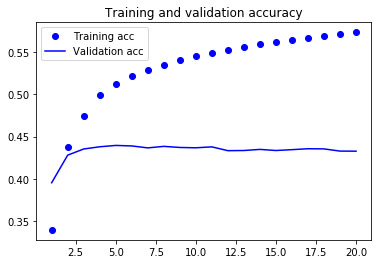

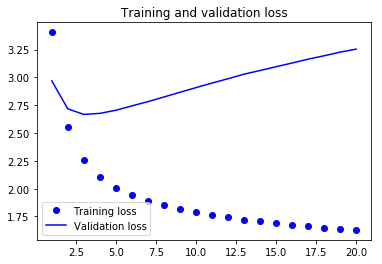

In [32]:
print ("best validation accuracy: ", max(history.history['val_acc']))
plot_train_history(history)

## 一层隐含层的神经网络
* 输入层
* 隐含层：全连接层
* 输出层：全连接层

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 126s 1ms/step - loss: 3.5590 - acc: 0.3021 - val_loss: 3.0527 - val_acc: 0.3711
Epoch 2/10
100000/100000 [==============================] - 122s 1ms/step - loss: 2.7648 - acc: 0.4034 - val_loss: 2.7337 - val_acc: 0.4041
Epoch 3/10
100000/100000 [==============================] - 125s 1ms/step - loss: 2.4898 - acc: 0.4427 - val_loss: 2.6122 - val_acc: 0.4241
Epoch 4/10
100000/100000 [==============================] - 126s 1ms/step - loss: 2.3280 - acc: 0.4686 - val_loss: 2.5518 - val_acc: 0.4313
Epoch 5/10
100000/100000 [==============================] - 123s 1ms/step - loss: 2.2121 - acc: 0.4880 - val_loss: 2.5182 - val_acc: 0.4362
Epoch 6/10
100000/100000 [==============================] - 124s 1ms/step - loss: 2.1200 - acc: 0.5028 - val_loss: 2.5037 - val_acc: 0.4399
Epoch 7/10
100000/100000 [==============================] - 118s 1ms/step - loss: 2.0423 - acc: 0.5156 - val_

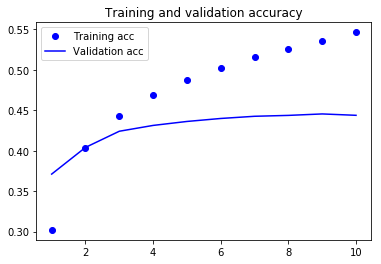

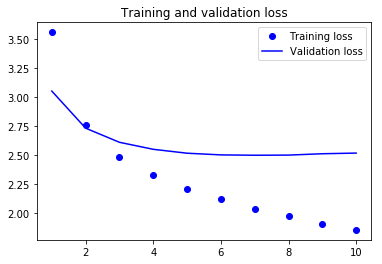

best validation accuracy:  0.445499999619


In [33]:
#设置模型输出维度
n_output_classes = y_dev_idx.shape[1]
#采用序贯模型
model = Sequential()
#加入全连接层1
model.add(Dense(128, activation='relu', input_shape=(num_words,)))
#加入全连接层2
model.add(Dense(n_output_classes, activation = 'softmax'))
#对模型进行编译
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#加入early stopping防止过拟合
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=1, mode='auto')
#对模型进行训练
history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 10,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks = [early])
#绘制曲线
plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## 两层隐含层的神经网络
* 输入层
* 隐含层1：全连接层
* 隐含层2：全连接层
* 输出层：全连接层

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 291s 3ms/step - loss: 3.5459 - acc: 0.3114 - val_loss: 3.0987 - val_acc: 0.3788
Epoch 2/20
100000/100000 [==============================] - 284s 3ms/step - loss: 2.8482 - acc: 0.4103 - val_loss: 2.8681 - val_acc: 0.4000
Epoch 3/20
100000/100000 [==============================] - 277s 3ms/step - loss: 2.6257 - acc: 0.4426 - val_loss: 2.7795 - val_acc: 0.4130
Epoch 4/20
100000/100000 [==============================] - 287s 3ms/step - loss: 2.4925 - acc: 0.4640 - val_loss: 2.7451 - val_acc: 0.4152
Epoch 5/20
100000/100000 [==============================] - 280s 3ms/step - loss: 2.3958 - acc: 0.4805 - val_loss: 2.7027 - val_acc: 0.4359
Epoch 6/20
100000/100000 [==============================] - 283s 3ms/step - loss: 2.3168 - acc: 0.4935 - val_loss: 2.6878 - val_acc: 0.4320
Epoch 7/20
100000/100000 [==============================] - 281s 3ms/step - loss: 2.2502 - acc: 0.5048 - val_

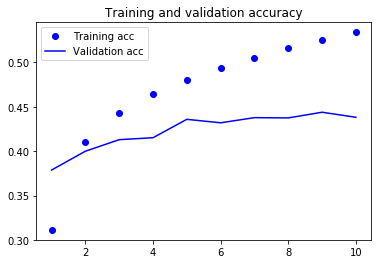

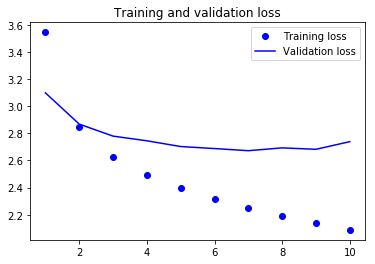

best validation accuracy:  0.443899999809


In [34]:
#设置模型输出维度
n_output_classes = y_dev_idx.shape[1]
#采用序贯模型
model = Sequential()
#加入全连接层1
model.add(Dense(300, activation='relu', input_shape=(num_words,)))
#加入全连接层2
model.add(Dense(128, activation='relu', 
                kernel_regularizer = regularizers.l2(0.0025)))
#加入全连接层3
model.add(Dense(n_output_classes, activation = 'softmax'))
#对模型进行编译
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#加入early stopping防止过拟合
early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')
#对模型进行训练
history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks=[early])
#绘制曲线
plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## 两层隐含层的神经网络：dropout和正则化
* 输入层
* 隐含层1：全连接层，dropout，L2正则化
* 隐含层2：全连接层，dropout，L2正则化
* 输出层：全连接层

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 285s 3ms/step - loss: 3.7345 - acc: 0.2658 - val_loss: 3.2544 - val_acc: 0.3400
Epoch 2/20
100000/100000 [==============================] - 292s 3ms/step - loss: 3.1098 - acc: 0.3594 - val_loss: 2.9630 - val_acc: 0.3811
Epoch 3/20
100000/100000 [==============================] - 281s 3ms/step - loss: 2.8802 - acc: 0.3925 - val_loss: 2.8649 - val_acc: 0.3925
Epoch 4/20
100000/100000 [==============================] - 291s 3ms/step - loss: 2.7486 - acc: 0.4154 - val_loss: 2.7769 - val_acc: 0.4055
Epoch 5/20
100000/100000 [==============================] - 275s 3ms/step - loss: 2.6536 - acc: 0.4297 - val_loss: 2.7140 - val_acc: 0.4140
Epoch 6/20
100000/100000 [==============================] - 299s 3ms/step - loss: 2.5808 - acc: 0.4422 - val_loss: 2.6890 - val_acc: 0.4223
Epoch 7/20
100000/100000 [==============================] - 292s 3ms/step - loss: 2.5219 - acc: 0.4538 - val_

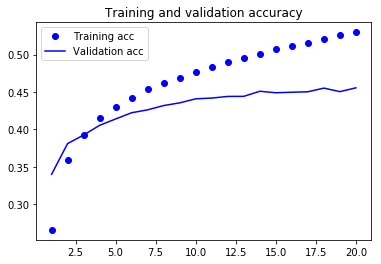

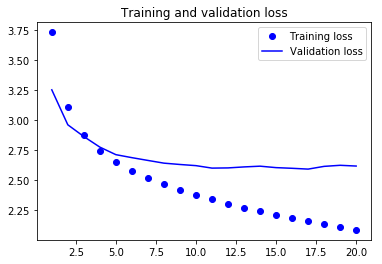

best validation accuracy:  0.455600000191


In [35]:
#设置模型输出维度
n_output_classes = y_dev_idx.shape[1]
#采用序贯模型
model = Sequential()
#加入全连接层1
model.add(Dense(300, activation='relu', input_shape=(num_words,)))
model.add(Dropout(0.4))
#加入全连接层2
model.add(Dense(128, activation='relu',
                kernel_regularizer = regularizers.l2(0.002)))
model.add(Dropout(0.4))
#加入全连接层3
model.add(Dense(n_output_classes, activation = 'softmax'))
#对模型进行编译
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#对模型进行训练
history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx))
#绘制曲线
plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## 加入embedding层的简单神经网络
* 输入层
* 隐含层1：embedding层
* 隐含层2:   flatten层
* 输出层：全连接层

In [38]:
#定义序列的最长长度为25
maxlen = 25
#对文本进行填充
def convert_to_sequences(tweet_text, tokenizer, maxlen=20):
    tweet_sequence = np.asarray(tokenizer.texts_to_sequences(tweet_text))
    padded = pad_sequences (tweet_sequence, maxlen=maxlen)
    return (padded)
#将train，dev，test集进行文本填充转换
x_train_sequences = convert_to_sequences(x_train, tokenizer, maxlen=maxlen)
x_dev_sequences = convert_to_sequences(x_dev, tokenizer, maxlen=maxlen)
x_test_sequences = convert_to_sequences(x_test, tokenizer, maxlen=maxlen)

In [39]:
#设置输出维度大小
n_output_classes = y_dev_idx.shape[1]

#定义embedding模型
def simple_embedding_model(num_words, n_output_classes, n_embedding_dims = 16, max_sequence_length = 20):
    #采用序贯模型
    model = Sequential()
    #加入embedding层
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 
    #加入flatten层，把tensor转化为2维（samples，maxlen*8）
    model.add(Flatten()) 
    #加入全连接层
    model.add(Dense(n_output_classes, activation = 'softmax'))
    #对模型进行编译
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return (model)

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 53s 528us/step - loss: 3.6874 - acc: 0.2466 - val_loss: 3.3586 - val_acc: 0.2949
Epoch 2/20
100000/100000 [==============================] - 53s 531us/step - loss: 3.0812 - acc: 0.3482 - val_loss: 3.0241 - val_acc: 0.3634
Epoch 3/20
100000/100000 [==============================] - 51s 513us/step - loss: 2.7921 - acc: 0.3930 - val_loss: 2.8662 - val_acc: 0.3863
Epoch 4/20
100000/100000 [==============================] - 53s 526us/step - loss: 2.6079 - acc: 0.4215 - val_loss: 2.7679 - val_acc: 0.4005
Epoch 5/20
100000/100000 [==============================] - 51s 510us/step - loss: 2.4671 - acc: 0.4469 - val_loss: 2.7009 - val_acc: 0.4152
Epoch 6/20
100000/100000 [==============================] - 52s 515us/step - loss: 2.3506 - acc: 0.4689 - val_loss: 2.6563 - val_acc: 0.4217
Epoch 7/20
100000/100000 [==============================] - 52s 520us/step - loss: 2.2491 - acc: 0.4870

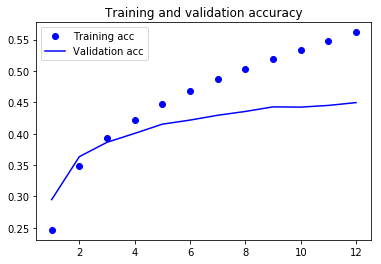

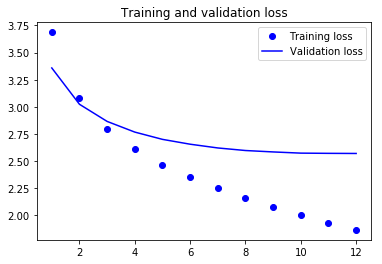

best validation accuracy:  0.449600000238


In [40]:
clear_session()
#定义模型
model = simple_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 64, 
                               max_sequence_length = maxlen)    
#加入early stopping防止过拟合
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=1, mode='auto')
#加入断点续训
checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_embedding.h5',
                                             monitor='val_acc',
                                             save_best_only = True)
#对模型进行可视化
tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
                                          #write_grads=1,
                                          #histogram_freq=1,
                                          embeddings_freq=1,
                                          embeddings_data='embedding') 
#对模型进行训练
history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 20,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])
#绘制曲线
plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## 加入embedding层的深层神经网络
* 输入层
* 隐含层1:  embedding层
* 隐含层2:  flatten层
* 隐含层3:  全连接层，dropout，L2正则化
* 隐含层4:  全连接层，dropout，L2正则化
* 输出层：全连接层

In [41]:
#定义deeper embedding模型
def deeper_embedding_model(num_words,
                           n_output_classes, 
                           n_embedding_dims = 16, 
                           max_sequence_length = 20, 
                           dense1_size = 16, 
                           dropout1_rate = 0.2,
                           dense2_size = 16,
                           dropout2_rate = 0.2,
                           lambd = 0.0):
    #采用序贯模型
    model = Sequential()
    #加入embedding层
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 
    #加入flatten层
    model.add(Flatten()) 
    #加入全连接层
    model.add(Dense(dense1_size, activation='relu'))
    model.add(Dropout(dropout1_rate))
    #加入全连接层
    model.add(Dense(dense2_size, activation='relu',
                    kernel_regularizer = regularizers.l2(lambd)))
    model.add(Dropout(dropout2_rate))
    #加入全连接层
    model.add(Dense(n_output_classes, activation = 'softmax'))
    #对模型进行编译
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return (model)

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 9s 93us/step - loss: 4.1497 - acc: 0.1401 - val_loss: 3.8496 - val_acc: 0.1870
Epoch 2/50
100000/100000 [==============================] - 9s 90us/step - loss: 3.7136 - acc: 0.2145 - val_loss: 3.5867 - val_acc: 0.2394
Epoch 3/50
100000/100000 [==============================] - 9s 94us/step - loss: 3.4921 - acc: 0.2519 - val_loss: 3.4058 - val_acc: 0.2492
Epoch 4/50
100000/100000 [==============================] - 9s 92us/step - loss: 3.3389 - acc: 0.2716 - val_loss: 3.2769 - val_acc: 0.2850
Epoch 5/50
100000/100000 [==============================] - 9s 95us/step - loss: 3.2277 - acc: 0.2872 - val_loss: 3.1911 - val_acc: 0.3029
Epoch 6/50
100000/100000 [==============================] - 9s 93us/step - loss: 3.1342 - acc: 0.3017 - val_loss: 3.1389 - val_acc: 0.3125
Epoch 7/50
100000/100000 [==============================] - 9s 93us/step - loss: 3.0508 - acc: 0.3145 - val_loss: 3

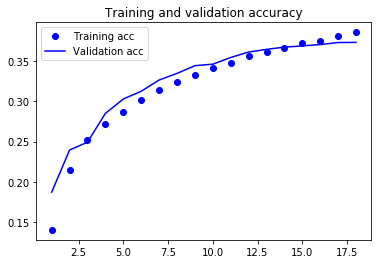

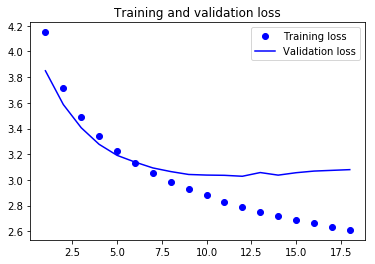

best validation accuracy:  0.373299999619


In [42]:
clear_session()
#定义模型
model = deeper_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 28, 
                               max_sequence_length = maxlen,
                               lambd = 0.0006)    
#加入early stopping防止过拟合
early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')
#加入断点续训
checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_embedding_v2.h5',
                                             monitor='val_acc',
                                             save_best_only = True)
#对模型进行训练
history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])
#绘制曲线
plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## 模型调参

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 118s 1ms/step - loss: 3.8416 - acc: 0.2339 - val_loss: 3.4264 - val_acc: 0.2807
Epoch 2/50
100000/100000 [==============================] - 113s 1ms/step - loss: 3.2374 - acc: 0.3188 - val_loss: 3.1183 - val_acc: 0.3419
Epoch 3/50
100000/100000 [==============================] - 113s 1ms/step - loss: 2.9419 - acc: 0.3620 - val_loss: 2.9644 - val_acc: 0.3543
Epoch 4/50
100000/100000 [==============================] - 114s 1ms/step - loss: 2.7393 - acc: 0.3956 - val_loss: 2.8728 - val_acc: 0.3827
Epoch 5/50
100000/100000 [==============================] - 114s 1ms/step - loss: 2.5777 - acc: 0.4259 - val_loss: 2.8493 - val_acc: 0.3894
Epoch 6/50
100000/100000 [==============================] - 114s 1ms/step - loss: 2.4418 - acc: 0.4517 - val_loss: 2.8721 - val_acc: 0.3955
Epoch 7/50
100000/100000 [==============================] - 113s 1ms/step - loss: 2.3195 - acc: 0.4733 - val_

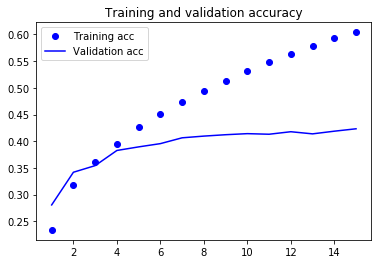

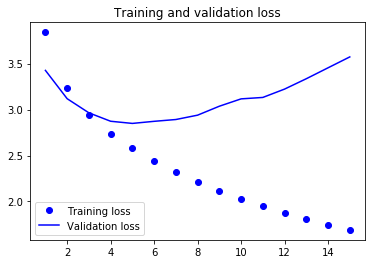

best validation accuracy:  0.423299999952


In [43]:
clear_session()
#定义模型
model = deeper_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 128,          #196      # 128
                               max_sequence_length = maxlen,
                               dense1_size = 128,               # 160     # 128
                               dropout1_rate = 0.4,           # 0.35
                               dense2_size = 96,             # 128   # 96
                               dropout2_rate = 0.4,           # 0.35
                               lambd = 0.0025)                # 0.0015
#加入early stopping防止过拟合                           
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=1, mode='auto')
#对模型进行训练
history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])
#绘制曲线
plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## LSTM模型
* 输入层
* 隐含层1：embedding层
* 隐含层2:  LSTM层
* 隐含层3:  全连接层，dropout，正则化
* 隐含层4:  全连接层，dropout，正则化
* 输出层：全连接层

In [44]:
#定义LSTM模型
def simple_lstm_model(num_words,
                           n_output_classes, 
                           n_embedding_dims = 16, 
                           max_sequence_length = 20, 
                           dense1_size = 16, 
                           dropout1_rate = 0.2,
                           lambd = 0.0):
    #采用序贯模型
    model = Sequential()
    #加入embedding层
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 
    #加入LSTM层
    model.add(LSTM(n_embedding_dims))
    # model.add(Flatten()) 
    #加入全连接层
    model.add(Dense(dense1_size, activation='relu'))
    model.add(Dropout(dropout1_rate))
    #加入全连接层
    model.add(Dense(n_output_classes, activation = 'softmax'))
    #对模型进行编译
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return (model)

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 518s 5ms/step - loss: 3.7990 - acc: 0.2091 - val_loss: 3.4835 - val_acc: 0.2438
Epoch 2/50
100000/100000 [==============================] - 512s 5ms/step - loss: 3.2601 - acc: 0.2866 - val_loss: 3.1406 - val_acc: 0.3138
Epoch 3/50
100000/100000 [==============================] - 518s 5ms/step - loss: 2.9365 - acc: 0.3506 - val_loss: 2.9370 - val_acc: 0.3532
Epoch 4/50
100000/100000 [==============================] - 520s 5ms/step - loss: 2.7323 - acc: 0.3901 - val_loss: 2.8541 - val_acc: 0.3695
Epoch 5/50
100000/100000 [==============================] - 522s 5ms/step - loss: 2.6019 - acc: 0.4158 - val_loss: 2.7398 - val_acc: 0.4027
Epoch 6/50
100000/100000 [==============================] - 513s 5ms/step - loss: 2.5117 - acc: 0.4341 - val_loss: 2.7195 - val_acc: 0.4069
Epoch 7/50
100000/100000 [==============================] - 532s 5ms/step - loss: 2.4403 - acc: 0.4469 - val_

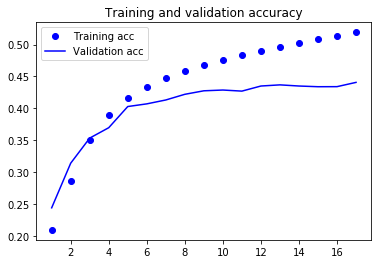

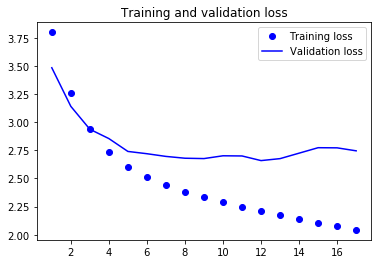

best validation accuracy:  0.440600000334


In [45]:
clear_session()
#定义模型
model = simple_lstm_model(num_words,
                          n_output_classes, 
                          n_embedding_dims = 90,          
                          max_sequence_length = maxlen,
                          dense1_size = 128,               
                          dropout1_rate = 0.2,           
                          lambd = 0.0025)                
#对模型进行可视化
tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log')
                                          #write_grads=1,
                                          #histogram_freq=1,
                                          #embeddings_freq=1,
                                          #embeddings_data='embedding') 
#加入early stopping防止过拟合  
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')
#对模型进行训练
history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early, tensorboard])
#绘制曲线
plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))